In [ ]:
import kagglehub
import shutil
import os

# Tải về dataset
path = kagglehub.dataset_download("seyeon040768/car-detection-dataset")
print("Path to original dataset files:", path)

# Tạo đường dẫn mới
target_path = "/content/car-detection-datasets"

# Copy sang thư mục mới trong /content/
shutil.copytree(path, target_path)

print("Dataset đã được sao chép tới:", target_path)


100%|██████████| 886M/886M [00:10<00:00, 88.9MB/s]

Extracting files...


Path to original dataset files: /root/.cache/kagglehub/datasets/seyeon040768/car-detection-dataset/versions/1
Dataset đã được sao chép tới: /content/car-detection-datasets


In [ ]:
import kagglehub
import shutil
import os

# Tải về dataset
path = kagglehub.dataset_download("jaydenguyenx/vietnamese-traffic-signs-detection-and-recognition")
print("Path to original dataset files:", path)

# Tạo đường dẫn mới
target_path = "/content/traffic-signs"

# Copy sang thư mục mới trong /content/
shutil.copytree(path, target_path)

print("Dataset đã được sao chép tới:", target_path)


100%|██████████| 1.32G/1.32G [00:13<00:00, 103MB/s]

Extracting files...


Path to original dataset files: /root/.cache/kagglehub/datasets/jaydenguyenx/vietnamese-traffic-signs-detection-and-recognition/versions/1
Dataset đã được sao chép tới: /content/traffic-signs


In [ ]:
# 🟢 CELL 1 – CÀI ĐẶT & KHAI BÁO ĐƯỜNG DẪN
#   - Import thư viện cần thiết
#   - Khai báo đường dẫn 2 bộ dữ liệu
# -------------------------------------------------
import os, random, shutil, json, cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from collections import defaultdict
from tqdm import tqdm

# Đảm bảo matplotlib hiển thị trong notebook
%matplotlib inline

# Đường dẫn tới 2 bộ dữ liệu
DIR_CAR      = "/content/car-detection-datasets/car_dataset-master"
DIR_TRAFFIC  = "/content/traffic-signs/train_data"

print("✅ Đã khai báo xong đường dẫn.")


✅ Đã khai báo xong đường dẫn.


In [ ]:
# In ra cây thư mục tối đa 2 tầng để xem thực tế có gì
import os
def xem_cay_thu_muc(dir_path, level=2):
    for root, dirs, files in os.walk(dir_path):
        depth = root[len(dir_path):].count(os.sep)
        if depth > level:    # chỉ hiển thị n cấp cho gọn
            continue
        indent = "  " * depth
        print(f"{indent}{os.path.basename(root)}/")
        # in thử tối đa 5 file đầu tiên mỗi thư mục
        for f in files[:5]:
            print(f"{indent}  {f}")

xem_cay_thu_muc(DIR_CAR)


car_dataset-master/
  README.md
  test/
    labels/
      008241.txt
      012343.txt
      004568.txt
      001020.txt
      000672.txt
    images/
      013143.jpg
      004421.jpg
      014708.jpg
      010412.jpg
      007324.jpg
  valid/
    labels/
      010238.txt
      002858.txt
      012354.txt
      002652.txt
      000767.txt
    images/
      003327.jpg
      002288.jpg
      014360.jpg
      014739.jpg
      013185.jpg
  train/
    labels/
      014471.txt
      016123.txt
      016179.txt
      000778.txt
      001288.txt
    images/
      006851.jpg
      006662.jpg
      006492.jpg
      004619.jpg
      007089.jpg


In [ ]:
# 🟢 CELL 2 – THỐNG KÊ SƠ BỘ CẤU TRÚC THƯ MỤC
#   - Liệt kê số lượng ảnh & nhãn ở từng split (train/val/test) cho mỗi bộ
# 🟢 CELL – THỐNG KÊ + IN CHI TIẾT
# -------------------------------------------------
from glob import glob
from collections import defaultdict
import os, re

def tim_thu_muc(base_dir, split, kiểu="images"):
    """
    Trả về path đến thư mục ảnh hoặc nhãn cho split (train/val/test/valid)
    dựa trên 3 pattern thông dụng.
    """
    alias = {"val": ["val", "valid"], "valid": ["valid", "val"]}.get(split,[split])
    patterns = [                                     # theo ưu tiên
        f"{split}/{kiểu}",                           # train/images
        f"{kiểu}/{split}",                           # images/train
        f"{split}_{kiểu}",                           # train_images
    ]
    # thử cả alias ("val" ↔ "valid")
    patterns += [p.replace(split,a) for a in alias for p in patterns]

    for p in patterns:
        full = os.path.join(base_dir, p)
        if os.path.isdir(full):
            return full
    return None   # không tìm thấy

def thong_ke_dataset_auto(base_dir, splits=("train","val","test"), verb=True):
    kq = defaultdict(dict)
    for sp in splits:
        img_dir = tim_thu_muc(base_dir, sp, "images")
        lbl_dir = tim_thu_muc(base_dir, sp, "labels")
        n_img   = len(glob(os.path.join(img_dir, "*.*g"))) if img_dir else 0
        n_lbl   = len(glob(os.path.join(lbl_dir, "*.txt"))) if lbl_dir else 0
        kq[sp]["imgs"], kq[sp]["lbls"] = n_img, n_lbl

        if verb:
            print(f"  • {sp:<5}: {n_img:>5} ảnh | {n_lbl:>5} nhãn   "
                  f"(img: {img_dir or '–'}, lbl: {lbl_dir or '–'})")
    if verb:
        print("  → Tổng:", sum(v["imgs"] for v in kq.values()),
              "ảnh;", sum(v["lbls"] for v in kq.values()), "nhãn\n")
    return kq

# 🆕 HÀM HỖ TRỢ – Lấy danh sách mọi thư mục ảnh/nhãn cho base_dir
def list_image_dirs(base_dir):
    """Trả về list tất cả thư mục chứa ảnh + nhãn theo 3 pattern thông dụng."""
    dirs = []
    for split in ["train", "val", "valid", "test"]:
        img_dir = tim_thu_muc(base_dir, split, "images")
        if img_dir:     # đảm bảo tồn tại
            lbl_dir = tim_thu_muc(base_dir, split, "labels")
            dirs.append((img_dir, lbl_dir))
    return dirs

# Gọi cho 2 bộ dữ liệu
for tên, d in [("🚗  CAR", DIR_CAR), ("🛑  TRAFFIC-SIGN", DIR_TRAFFIC)]:
    print(f"\n=== {tên} ({d}) ===")
    thong_ke_dataset_auto(d)


=== 🚗  CAR (/content/car-detection-datasets/car_dataset-master) ===
  • train: 12949 ảnh | 12949 nhãn   (img: /content/car-detection-datasets/car_dataset-master/train/images, lbl: /content/car-detection-datasets/car_dataset-master/train/labels)
  • val  :  1618 ảnh |  1618 nhãn   (img: /content/car-detection-datasets/car_dataset-master/valid/images, lbl: /content/car-detection-datasets/car_dataset-master/valid/labels)
  • test :  1618 ảnh |  1618 nhãn   (img: /content/car-detection-datasets/car_dataset-master/test/images, lbl: /content/car-detection-datasets/car_dataset-master/test/labels)
  → Tổng: 16185 ảnh; 16185 nhãn


=== 🛑  TRAFFIC-SIGN (/content/traffic-signs/train_data) ===
  • train:   900 ảnh |   900 nhãn   (img: /content/traffic-signs/train_data/images/train, lbl: /content/traffic-signs/train_data/labels/train)
  • val  :   180 ảnh |   180 nhãn   (img: /content/traffic-signs/train_data/images/val, lbl: /content/traffic-signs/train_data/labels/val)
  • test :    90 ảnh |    

🔍  Hình mẫu CAR:


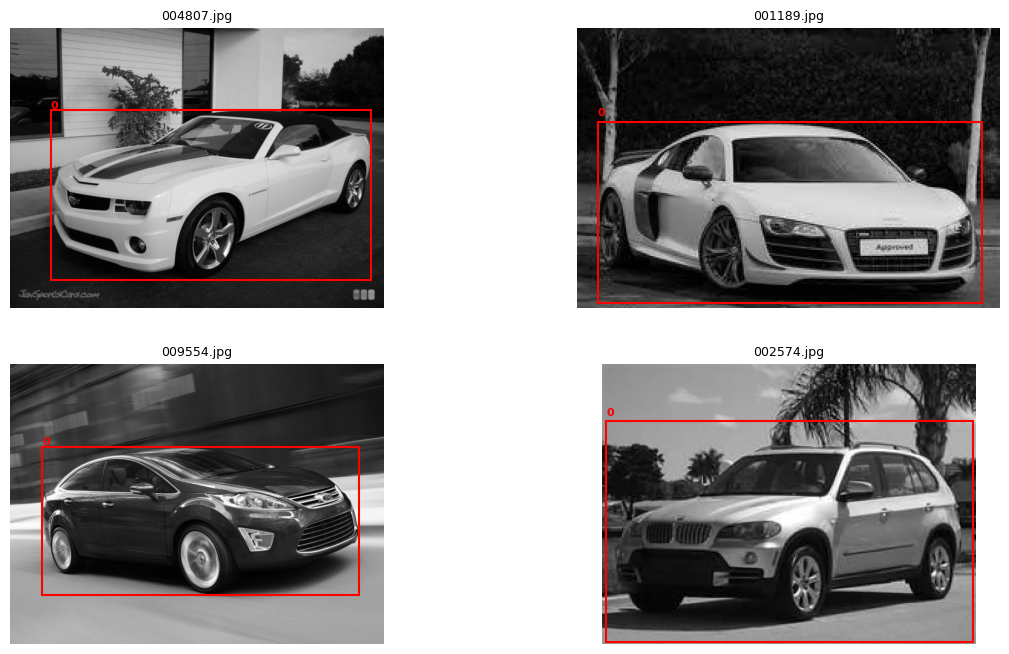

🔍  Hình mẫu TRAFFIC-SIGN:


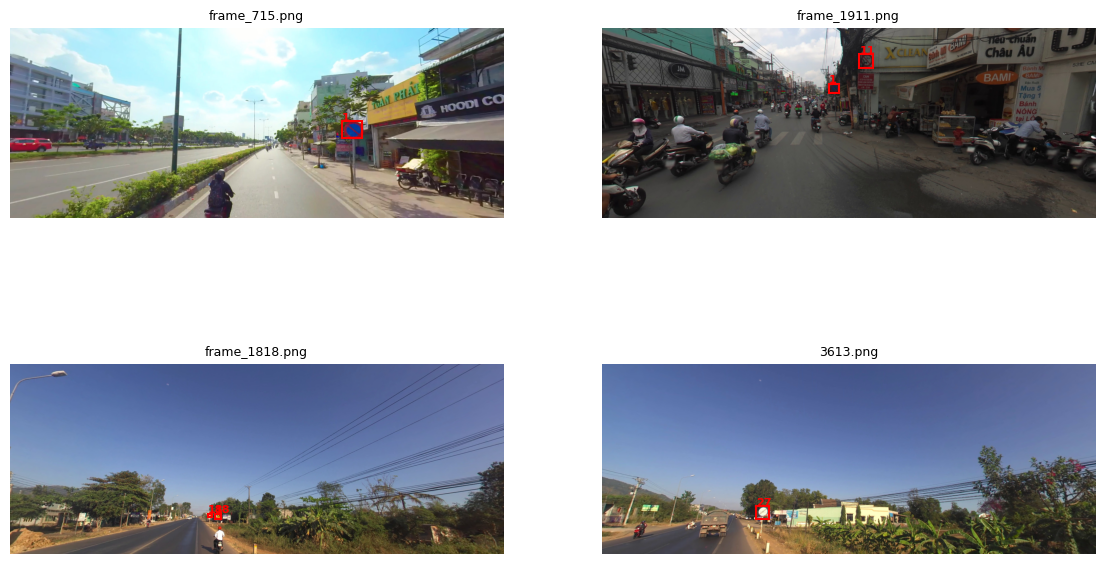

In [ ]:
# 🟢 CELL 3 – XEM MẪU ẢNH + BOUNDING BOX
#   - Chọn ngẫu nhiên 4 ảnh bất kỳ, vẽ bbox để kiểm tra nhãn
# -------------------------------------------------
def doc_nhan(label_path):
    """Đọc file .txt YOLO -> Trả về list [class, x_center, y_center, w, h] (float)."""
    with open(label_path) as f:
        rows = [list(map(float, line.strip().split())) for line in f if line.strip()]
    return rows

def ve_bbox(ax, box, w, h, cls, color="r"):
    xc, yc, bw, bh = box[1:]          # (giữ nguyên theo YOLO)
    x1 = int((xc - bw/2) * w); y1 = int((yc - bh/2) * h)
    x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
    ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                 fill=False, edgecolor=color, linewidth=1.5))
    ax.text(x1, y1-4, str(int(cls)), color=color, fontsize=8, weight="bold")

def xem_mau(base_dir, so_anh=4):
    # gom tất cả file ảnh ở mọi split
    img_files = []
    for img_dir, _ in list_image_dirs(base_dir):
        img_files.extend(glob(os.path.join(img_dir, "*.*g")))
    if not img_files:
        print("⛔ Không tìm thấy ảnh trong", base_dir); return

    samp = random.sample(img_files, min(so_anh, len(img_files)))

    plt.figure(figsize=(14, 8))
    for i, img_path in enumerate(samp, 1):
        # tự động suy ra label path
        lbl_path = None
        for img_dir, lbl_dir in list_image_dirs(base_dir):
            if img_path.startswith(img_dir):
                lbl_path = img_path.replace(img_dir, lbl_dir).rsplit(".",1)[0]+".txt"
                break

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        ax = plt.subplot(2, 2, i); ax.imshow(img); ax.axis("off")

        if lbl_path and os.path.exists(lbl_path):
            for row in doc_nhan(lbl_path):
                ve_bbox(ax, row, w, h, row[0])
        ax.set_title(os.path.basename(img_path), fontsize=9)
    plt.show()

print("🔍  Hình mẫu CAR:")
xem_mau(DIR_CAR)

print("🔍  Hình mẫu TRAFFIC-SIGN:")
xem_mau(DIR_TRAFFIC)


In [ ]:
# 🟢 CELL 4 – KIỂM TRA & LÀM SẠCH DỮ LIỆU
#   - Phát hiện file hỏng, nhãn thiếu, mismatch tỉ lệ bbox, …
#   - Di chuyển file lỗi vào thư mục _bad để tránh ảnh hưởng khi train
# -------------------------------------------------
def lam_sach(base_dir):
    bad_dir = os.path.join(base_dir, "_bad")
    os.makedirs(bad_dir, exist_ok=True)
    loi_dem = 0

    for img_dir, lbl_dir in list_image_dirs(base_dir):
        img_files = glob(os.path.join(img_dir, "*.*g"))
        for img_path in tqdm(img_files, desc=f"Quét {img_dir.split(base_dir)[-1]}"):
            lbl_path = img_path.replace(img_dir, lbl_dir).rsplit(".",1)[0]+".txt"

            if not os.path.exists(lbl_path):           # 1️⃣ thiếu nhãn
                shutil.move(img_path, bad_dir); loi_dem += 1; continue
            img = cv2.imread(img_path)
            if img is None:                            # 2️⃣ ảnh hỏng
                shutil.move(img_path, bad_dir)
                shutil.move(lbl_path, bad_dir); loi_dem += 1; continue
            try:                                       # 3️⃣ bbox ngoài [0,1]
                for row in doc_nhan(lbl_path):
                    if any(not (0 <= v <= 1) for v in row[1:]):
                        raise ValueError
            except Exception:
                shutil.move(img_path, bad_dir)
                shutil.move(lbl_path, bad_dir); loi_dem += 1

    print(f"🔧  Đã di chuyển {loi_dem} cặp ảnh/nhãn lỗi vào {bad_dir}")

lam_sach(DIR_CAR)
lam_sach(DIR_TRAFFIC)


Quét /test/images: 100%|██████████| 1618/1618 [00:04<00:00, 396.41it/s]


🔧  Đã di chuyển 0 cặp ảnh/nhãn lỗi vào /content/car-detection-datasets/car_dataset-master/_bad


Quét /images/test: 100%|██████████| 90/90 [00:02<00:00, 31.26it/s]

🔧  Đã di chuyển 0 cặp ảnh/nhãn lỗi vào /content/traffic-signs/train_data/_bad


In [ ]:
# 🟢 CELL 5 – TỔNG KẾT SAU KHI LÀM SẠCH
#   - In lại thống kê để thấy thay đổi
# -------------------------------------------------
for name, d in [("🚗  CAR", DIR_CAR), ("🛑  TRAFFIC-SIGN", DIR_TRAFFIC)]:
    print(f"\n{name}   ({d}):")
    s = thong_ke_dataset_auto(d)
    for sp in s:
        print(f"  • {sp:<5}: {s[sp]['imgs']:>5} ảnh  |  {s[sp]['lbls']:>5} nhãn")



🚗  CAR   (/content/car-detection-datasets/car_dataset-master):
  • train: 12949 ảnh | 12949 nhãn   (img: /content/car-detection-datasets/car_dataset-master/train/images, lbl: /content/car-detection-datasets/car_dataset-master/train/labels)
  • val  :  1618 ảnh |  1618 nhãn   (img: /content/car-detection-datasets/car_dataset-master/valid/images, lbl: /content/car-detection-datasets/car_dataset-master/valid/labels)
  • test :  1618 ảnh |  1618 nhãn   (img: /content/car-detection-datasets/car_dataset-master/test/images, lbl: /content/car-detection-datasets/car_dataset-master/test/labels)
  → Tổng: 16185 ảnh; 16185 nhãn

  • train: 12949 ảnh  |  12949 nhãn
  • val  :  1618 ảnh  |   1618 nhãn
  • test :  1618 ảnh  |   1618 nhãn

🛑  TRAFFIC-SIGN   (/content/traffic-signs/train_data):
  • train:   900 ảnh |   900 nhãn   (img: /content/traffic-signs/train_data/images/train, lbl: /content/traffic-signs/train_data/labels/train)
  • val  :   180 ảnh |   180 nhãn   (img: /content/traffic-signs/tr

In [ ]:
# 🆕 CELL – THỐNG KÊ CLASS & TÌM FILE ĐỊNH NGHĨA
import os, yaml, json
from glob import glob
from collections import Counter, defaultdict

def thong_ke_class(base_dir, tên_ds):
    counter = Counter()
    for _, lbl_dir in list_image_dirs(base_dir):
        for lbl_path in glob(os.path.join(lbl_dir, "*.txt")):
            with open(lbl_path) as f:
                for line in f:
                    if not line.strip(): continue
                    cls_id = int(float(line.split()[0]))
                    counter[cls_id] += 1

    print(f"\n📊 {tên_ds} – THỐNG KÊ CLASS:")
    for cls, n in sorted(counter.items()):
        print(f"  ID {cls:<3}: {n:>6} bbox")
    print(f"  → Tổng {sum(counter.values())} bbox, {len(counter)} class\n")
    return counter

def tim_va_in_file(base_dir, patterns=("classes.txt","obj.names","data.yaml","*.yaml","*.yml")):
    for pat in patterns:
        files = glob(os.path.join(base_dir, pat))
        if files:
            path = files[0]
            print(f"📄 Tìm thấy file định nghĩa: {path}")
            with open(path, errors="ignore") as f:
                txt = f.read()
            # Thử parse YAML nếu là .yaml
            if path.endswith((".yaml",".yml")):
                try:
                    data = yaml.safe_load(txt)
                    if isinstance(data, dict) and "names" in data:
                        txt = "\n".join([f"{k}: {v}" for k,v in data["names"].items()])
                except Exception: pass
            print(txt[:1000] + ("…" if len(txt)>1000 else ""))
            return
    print("⚠️  Không tìm thấy file class (.names/.txt/.yaml) trong", base_dir)

# Gọi cho 2 bộ dữ liệu
car_stat  = thong_ke_class(DIR_CAR, "CAR DATASET")
sign_stat = thong_ke_class(DIR_TRAFFIC, "TRAFFIC-SIGN DATASET")

# Thử tìm file định nghĩa class
tim_va_in_file(DIR_TRAFFIC)



📊 CAR DATASET – THỐNG KÊ CLASS:
  ID 0  :  17803 bbox
  → Tổng 17803 bbox, 1 class


📊 TRAFFIC-SIGN DATASET – THỐNG KÊ CLASS:
  ID 0  :    370 bbox
  ID 1  :    241 bbox
  ID 2  :    183 bbox
  ID 3  :     85 bbox
  ID 4  :     49 bbox
  ID 5  :     25 bbox
  ID 6  :     20 bbox
  ID 8  :     53 bbox
  ID 9  :     76 bbox
  ID 10 :     85 bbox
  ID 11 :    199 bbox
  ID 12 :    213 bbox
  ID 13 :    173 bbox
  ID 14 :    310 bbox
  ID 15 :     12 bbox
  ID 16 :     33 bbox
  ID 17 :     67 bbox
  ID 18 :    227 bbox
  ID 19 :    164 bbox
  ID 20 :     90 bbox
  ID 21 :     21 bbox
  ID 22 :     95 bbox
  ID 23 :     53 bbox
  ID 24 :    217 bbox
  ID 25 :     67 bbox
  ID 27 :     23 bbox
  ID 28 :     44 bbox
  → Tổng 3195 bbox, 27 class

📄 Tìm thấy file định nghĩa: /content/traffic-signs/train_data/classes.txt
one way prohibition
no parking
no stopping and parking
no turn left
no turn right
no u turn
no u and left turn
no u and right turn
no motorbike entry/turning
no car entry/turn

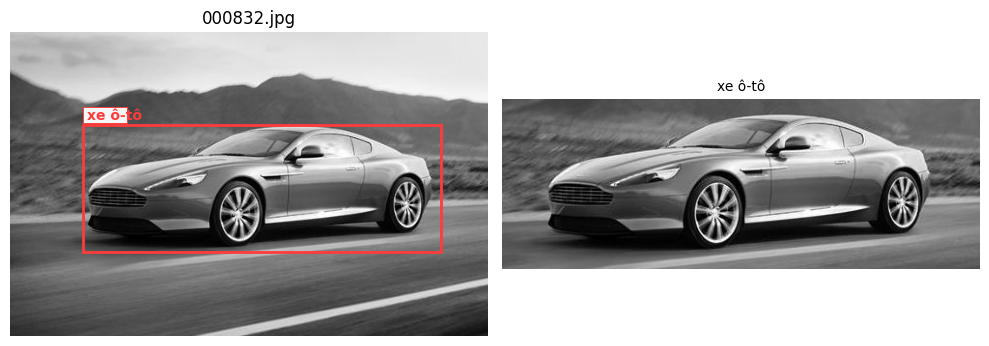

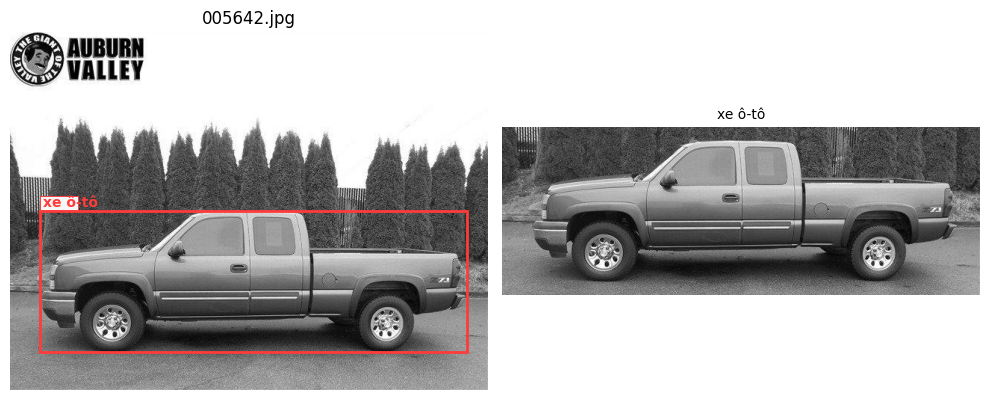

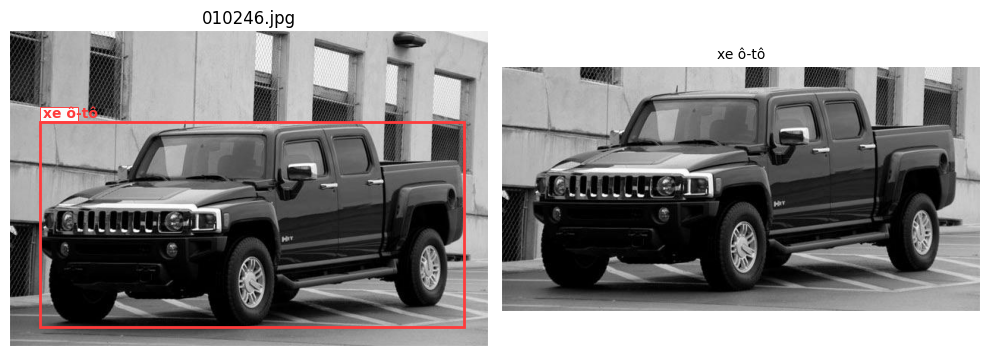

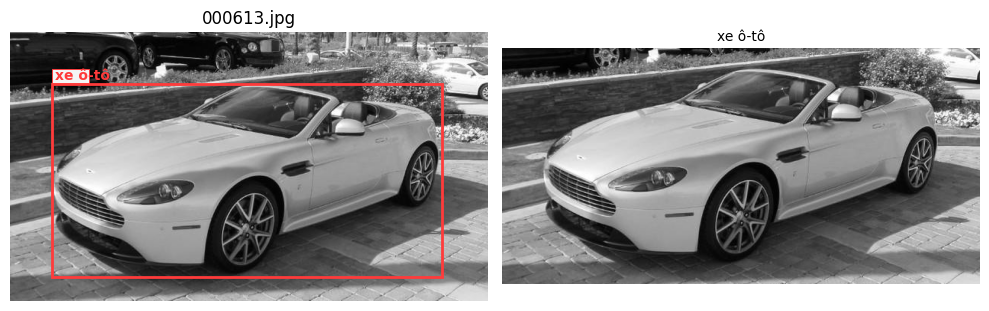

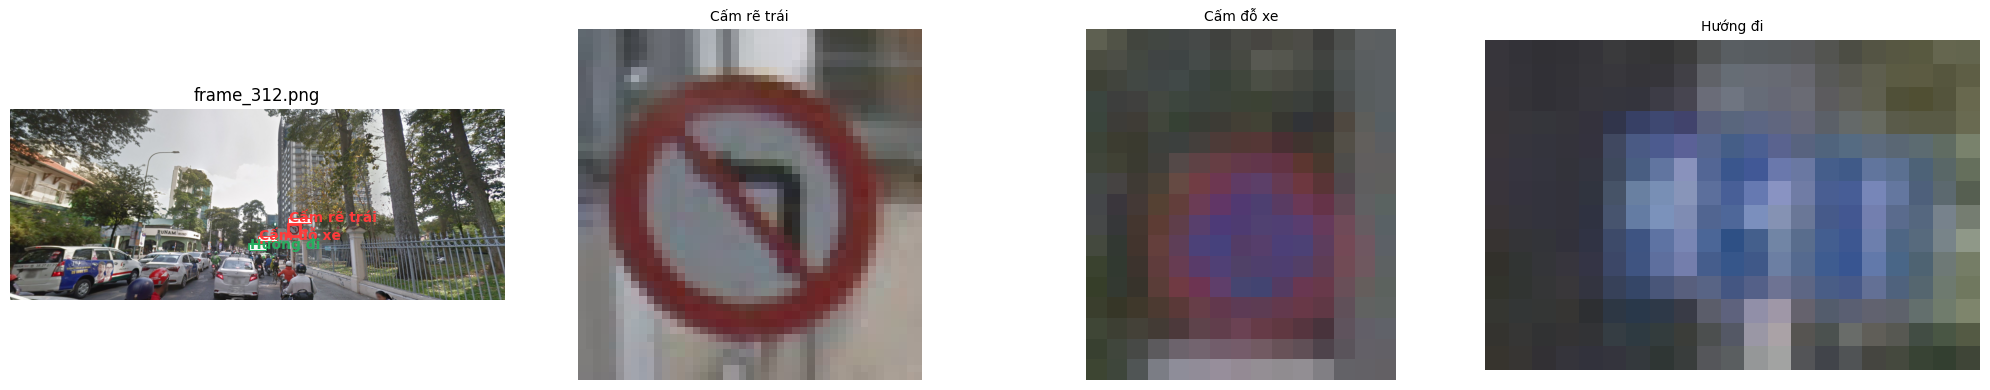

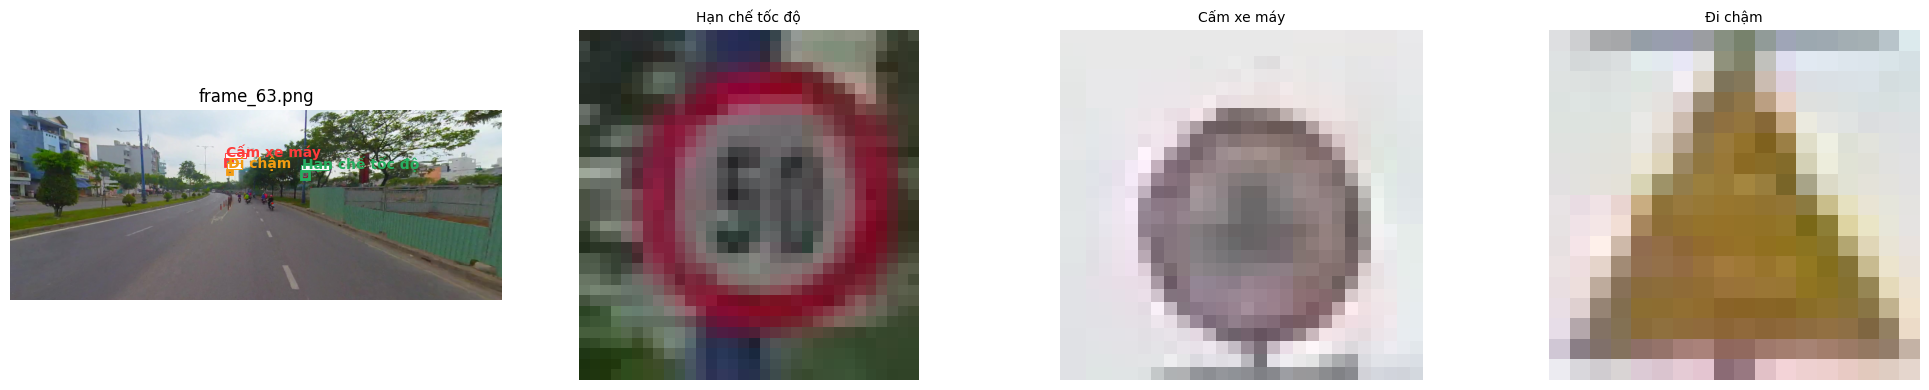

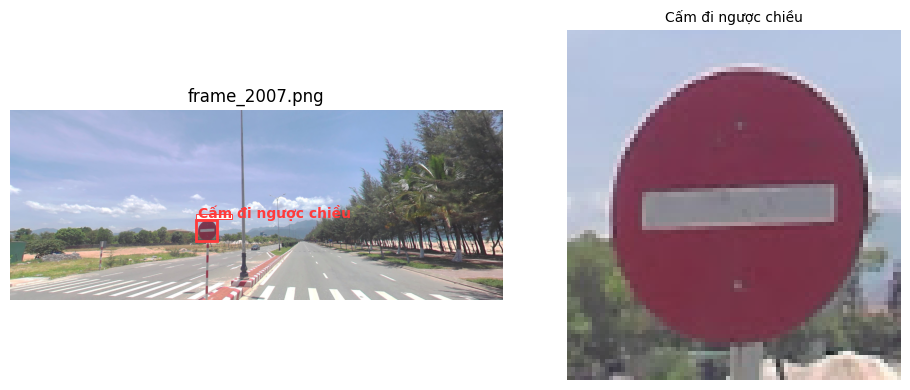

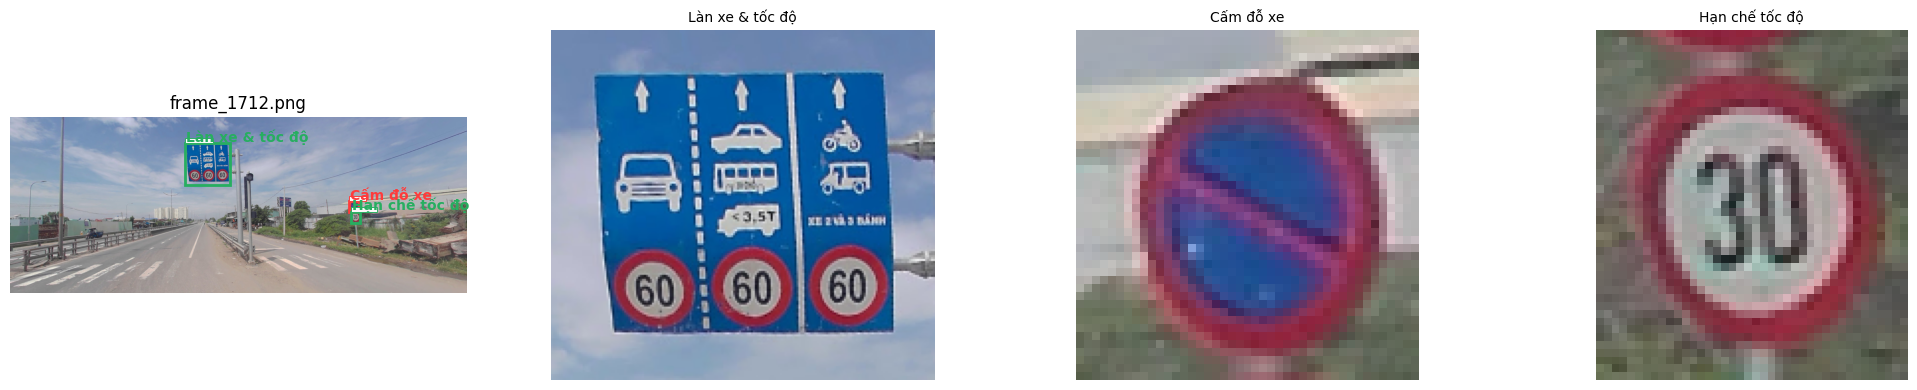

In [ ]:
# 🟢 CELL – HIỂN THỊ ẢNH + ROI PHÓNG TO
import os, random, cv2, matplotlib.pyplot as plt
from glob import glob
from matplotlib.patches import Rectangle
from textwrap import shorten

# ========= BẢNG TÊN =========
TEN_CAR = {0: "xe ô-tô"}
TEN_BIEN_VI = {
     0: "Cấm đi ngược chiều",          1: "Cấm đỗ xe",
     2: "Cấm dừng & đỗ",              3: "Cấm rẽ trái",
     4: "Cấm rẽ phải",                5: "Cấm quay đầu",
     6: "Cấm quay đầu & rẽ trái",     7: "Cấm quay đầu & rẽ phải",
     8: "Cấm xe máy",                 9: "Cấm ô-tô",
    10: "Cấm xe tải",                11: "Biển cấm khác",
    12: "Chỉ dẫn",                  13: "Hướng đi",
    14: "Hạn chế tốc độ",            15: "Giới hạn tải trọng",
    16: "Giới hạn chiều cao",        17: "Vạch sang đường",
    18: "Nguy hiểm giao nhau",       19: "Nguy hiểm đường trơn",
    20: "Nguy hiểm người đi bộ",     21: "Công trường",
    22: "Đi chậm",                   23: "Cảnh báo khác",
    24: "Làn xe được phép",          25: "Làn xe & tốc độ",
    26: "Cầu vượt",                 27: "Hết cấm",
    28: "Khác"
}

# ========= MÀU THEO NHÓM =========
COLOR = {"prohibit":"#ff3b3b","warn":"#f39c12","guide":"#27ae60"}
def get_color(c):
    c=int(c)
    return COLOR["prohibit"] if c<=11 else COLOR["warn"] if 18<=c<=23 else COLOR["guide"]

# ========= HÀM PHỤ =========
def list_dirs(base):
    res=[]
    for sp in ("train","val","valid","test"):
        for pat in (f"{sp}/images", f"images/{sp}"):
            d=os.path.join(base,pat)
            if os.path.isdir(d): res.append((d,d.replace("/images","/labels")))
    return res

def read_lbl(p):
    with open(p) as f:
        return [list(map(float,l.split())) for l in f if l.strip()]

def crop_roi(img, box, pad=0.1):
    h,w,_=img.shape
    xc,yc,bw,bh=box[1:]
    x1,y1 = (xc-bw/2-pad*bw)*w, (yc-bh/2-pad*bh)*h
    x2,y2 = (xc+bw/2+pad*bw)*w, (yc+bh/2+pad*bh)*h
    x1,y1,x2,y2 = map(int,[max(0,x1),max(0,y1),min(w,x2),min(h,y2)])
    return img[y1:y2, x1:x2]

# ========= VẼ KHUNG & NHÃN =========
def draw_bbox(ax, box, W, H, cls, names, used, scale):
    xc,yc,bw,bh=box[1:]; x1,y1=int((xc-bw/2)*W),int((yc-bh/2)*H)
    x2,y2=int((xc+bw/2)*W),int((yc+bh/2)*H)
    col=get_color(cls); lw=max(2,int(2*scale))
    ax.add_patch(Rectangle((x1,y1),x2-x1,y2-y1,fill=False,edgecolor=col,linewidth=lw))

    lab=shorten(names.get(int(cls),f"id:{int(cls)}"),24,placeholder="…")
    tw,th=len(lab)*6*scale+8, int(18*scale)
    tx,ty=x1,y1-th-2
    if ty<0: ty=y1+2
    def ov(a,b): return not(a[0]+a[2]<b[0] or b[0]+b[2]<a[0] or a[1]+a[3]<b[1] or b[1]+b[3]<a[1])
    while any(ov((tx,ty,tw,th),r) for r in used):
        ty+=th+2
        if ty+th>H: tx+=tw+4; ty=max(0,y1-th-2)
    used.append((tx,ty,tw,th))
    ax.add_patch(Rectangle((tx,ty),tw,th,facecolor="white",alpha=.96,edgecolor=col,linewidth=.7))
    ax.text(tx+4,ty+th-4,lab,color=col,fontsize=int(10*scale),weight="bold")

# ========= HÀM CHÍNH =========
def show_sample(base, names, n=4, max_roi=4, pad=0.1):
    dirs=list_dirs(base)
    imgs=[p for d,_ in dirs for p in glob(os.path.join(d,"*.*g"))]
    if not imgs: return print("⛔ Không tìm ảnh")
    samp=random.sample(imgs,min(n,len(imgs)))

    for p in samp:
        # -------- load & nhãn ----------
        lbl=None
        for idir,ldir in dirs:
            if p.startswith(idir):
                lbl=p.replace(idir,ldir).rsplit(".",1)[0]+".txt"; break
        img=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
        H,W,_=img.shape; scale=max(1,min(W,H)/800)

        # -------- figure ----------
        cols=1+min(max_roi,len(open(lbl).read().strip().splitlines())) if lbl else 1
        fig,axs=plt.subplots(1,cols,figsize=(cols*5,4))
        if cols==1: axs=[axs]

        # gốc
        axs[0].imshow(img); axs[0].axis("off"); axs[0].set_title(os.path.basename(p))
        used=[]
        if lbl and os.path.exists(lbl):
            rows=read_lbl(lbl)
            for r in rows: draw_bbox(axs[0],r,W,H,r[0],names,used,scale)

            # -------- ROI ----------
            for j,r in enumerate(rows[:max_roi],1):
                roi=crop_roi(img,r,pad); axs[j].imshow(roi); axs[j].axis("off")
                axs[j].set_title(names.get(int(r[0]),r[0]),fontsize=10)
        plt.tight_layout(); plt.show()

# ========== THỬ ==========
show_sample(DIR_CAR, TEN_CAR)          # xe
show_sample(DIR_TRAFFIC, TEN_BIEN_VI)  # biển báo


In [ ]:
# 🟢 CELL 0 – CÀI LIB (dùng Torch 2.3 để tránh lỗi Unpickling)
# ------------------------------------------------------------
# 1) Gỡ bản torch 2.6 mới cài
!pip uninstall -y torch torchvision torchaudio -q

# 2) Cài Torch 2.3 + CUDA 11.8 (tương thích Colab GPU T4/V100)
!pip install --no-cache-dir torch==2.3.0+cu118 torchvision==0.18.0+cu118 torchaudio==2.3.0+cu118 \
        -f https://download.pytorch.org/whl/torch_stable.html  -q

# 3) Cài Ultralytics (YOLOv8/YOLOv11)
!pip install ultralytics==8.1.25 -q

# 4) Kiểm tra
import torch, yaml, os, shutil, random, cv2, json
print("✅ Torch version:", torch.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 271.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 204.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 193.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 141.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 174.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 325.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 334.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 145.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 211.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 196.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 243.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --no-cache-dir torch==2.3.0+cu118 torchvision==0.18.0+cu118 torchaudio==2.3.0+cu118 \
        -f https://download.pytorch.org/whl/torch_stable.html  -q

# 3) Cài Ultralytics (YOLOv8/YOLOv11)
!pip install ultralytics==8.1.25 -q

# 4) Kiểm tra
import torch, yaml, os, shutil, random, cv2, json
print("✅ Torch version:", torch.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 208.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 196.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 218.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 211.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 202.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 263.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 311.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 258.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 259.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 224.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 328.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 🟢 CELL 1 – TẠO YAML DATASET
ROOT = "/content"      # thư mục gốc Colab (đã chứa 2 bộ dữ liệu)

def gen_yaml(name, base_dir, class_names):
    data = {
        "path": base_dir,
        "train":  "train/images",
        "val":    "valid/images" if os.path.isdir(f"{base_dir}/valid") else "images/val",
        "test":   "test/images",
        "names":  class_names
    }
    with open(f"{name}.yaml","w") as f: yaml.dump(data, f)
    print(f"📄 Đã tạo {name}.yaml")

# 1 class car
gen_yaml("car_det",      DIR_CAR,      {0: "xe ô-tô"})
# 29 class biển báo (⊃ 28 + “Khác” nếu muốn)
gen_yaml("sign_det", "/content/traffic-signs", TEN_BIEN_VI)


📄 Đã tạo car_det.yaml
📄 Đã tạo sign_det.yaml


In [ ]:
# 🟢 RE-CELL – TẠO YAML BIỂN BÁO CHUẨN
SIGN_ROOT = "/content/traffic-signs/train_data"   # <-- đổi thành train_data

sign_yaml = {
    "path":  SIGN_ROOT,
    "train": "images/train",
    "val":   "images/val",
    "test":  "images/test",
    "names": TEN_BIEN_VI          # dict {0:"Cấm..", 1:"Cấm đỗ xe", ...}
}

import yaml, json, os
with open("sign_det.yaml", "w") as f:
    yaml.dump(sign_yaml, f, allow_unicode=True)

print("📄 sign_det.yaml đã cập nhật! Nội dung:")
print(json.dumps(sign_yaml, indent=2, ensure_ascii=False))


📄 sign_det.yaml đã cập nhật! Nội dung:
{
  "path": "/content/traffic-signs/train_data",
  "train": "images/train",
  "val": "images/val",
  "test": "images/test",
  "names": {
    "0": "Cấm đi ngược chiều",
    "1": "Cấm đỗ xe",
    "2": "Cấm dừng & đỗ",
    "3": "Cấm rẽ trái",
    "4": "Cấm rẽ phải",
    "5": "Cấm quay đầu",
    "6": "Cấm quay đầu & rẽ trái",
    "7": "Cấm quay đầu & rẽ phải",
    "8": "Cấm xe máy",
    "9": "Cấm ô-tô",
    "10": "Cấm xe tải",
    "11": "Biển cấm khác",
    "12": "Chỉ dẫn",
    "13": "Hướng đi",
    "14": "Hạn chế tốc độ",
    "15": "Giới hạn tải trọng",
    "16": "Giới hạn chiều cao",
    "17": "Vạch sang đường",
    "18": "Nguy hiểm giao nhau",
    "19": "Nguy hiểm đường trơn",
    "20": "Nguy hiểm người đi bộ",
    "21": "Công trường",
    "22": "Đi chậm",
    "23": "Cảnh báo khác",
    "24": "Làn xe được phép",
    "25": "Làn xe & tốc độ",
    "26": "Cầu vượt",
    "27": "Hết cấm",
    "28": "Khác"
  }
}


In [ ]:
# 🟢 CELL 2 – TRAIN YOLOv11 CHO XE
!yolo detect train data=/content/car_det.yaml  model=/content/yolov8n.pt  epochs=50 imgsz=640 batch=32 \
   name=car_yolo11  optimizer=SGD lr0=0.01


New https://pypi.org/project/ultralytics/8.3.167 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.25 🚀 Python-3.11.13 torch-2.3.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8n.pt, data=/content/car_det.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=car_yolo112, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

In [ ]:
# 🟢 CELL 3 – TRAIN YOLOv11 CHO BIỂN BÁO
!yolo detect train data=/content/sign_det.yaml model=yolov8s.pt  epochs=120 imgsz=960 batch=16 \
   name=sign_yolo8 optimizer=AdamW lr0=0.002

New https://pypi.org/project/ultralytics/8.3.167 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.25 🚀 Python-3.11.13 torch-2.3.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/sign_det.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=sign_yolo85, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

In [ ]:
# ✅ Tiếp tục fine-tune sign_yolo85 thêm 20 epoch
!yolo detect train \
    data=/content/sign_det.yaml \
    model=/content/runs/detect/sign_yolo85/weights/last.pt \
    resume=True \
    epochs=140 \
    lr0=1e-4 \
    close_mosaic=0 \
    mosaic=0.5 \
    name=sign_yolo85_ft



New https://pypi.org/project/ultralytics/8.3.168 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.25 🚀 Python-3.11.13 torch-2.3.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/sign_yolo85/weights/last.pt, data=/content/sign_det.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=sign_yolo852, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

In [ ]:
!yolo detect train \
     data=sign_det.yaml \
     model=runs/detect/car_yolo112/weights/best.pt \
     freeze=10 \
     epochs=80 imgsz=960 batch=16 \
     optimizer=AdamW lr0=0.002 \
     name=sign_from_car


In [ ]:
# 🟢 CELL 4 – INFERENCE THỬ (gộp 2 model)
from ultralytics import YOLO
import matplotlib.pyplot as plt

mdl_car  = YOLO("runs/detect/car_yolo112/weights/best.pt")
mdl_sign = YOLO("runs/detect/sign_yolo11/weights/best.pt")

def detect_and_show(img_path):
    img = cv2.imread(img_path)
    res1 = mdl_car(img, verbose=False)[0]
    res2 = mdl_sign(img, verbose=False)[0]

    # gộp kết quả
    res1.boxes.cls += 100   # tránh trùng id
    res_all = res1 + res2

    # vẽ
    for box in res_all.boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        cls = int(box.cls)
        score = box.conf.item()
        if cls >= 100:                 # biển báo
            cls -= 100
            name  = TEN_BIEN_VI.get(cls,"khác")
            color = (0,140,255)        # cam
        else:                          # xe
            name  = "xe ô-tô"
            color = (0,0,255)          # đỏ
        cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
        cv2.putText(img,f"{name} {score:.2f}",(x1,y1-4),
                    cv2.FONT_HERSHEY_SIMPLEX,0.6,color,2)

    plt.figure(figsize=(8,4)); plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.show()

detect_and_show("/content/traffic-signs/train_data/images/val/frame_1863.png")


In [ ]:
# 🟢 CELL 5 – CROPS -> folders
OUT_CROP = "/content/sign_crops"
shutil.rmtree(OUT_CROP, ignore_errors=True)

for split in ("train","val"):
    img_dir = f"{DIR_TRAFFIC}/images/{split}"
    lbl_dir = img_dir.replace("/images/","/labels/")
    for img_p in glob(f"{img_dir}/*.*g"):
        lbl_p = img_p.replace(img_dir,lbl_dir).rsplit(".",1)[0]+".txt"
        if not os.path.exists(lbl_p): continue
        img = cv2.imread(img_p)
        for i,row in enumerate(doc_nhan(lbl_p)):
            cls = int(row[0]); crop = crop_roi(img,row,0.1)
            cls_name = TEN_BIEN_VI[cls]
            save_dir = f"{OUT_CROP}/{split}/{cls_name}"
            os.makedirs(save_dir, exist_ok=True)
            cv2.imwrite(f"{save_dir}/{os.path.basename(img_p)[:-4]}_{i}.jpg", crop)

print("✅ Đã cắt xong ROI:", len(glob(f'{OUT_CROP}/train/*/*.jpg')), "ảnh")


In [ ]:
# 🟢 CELL 6 – TRAIN CNN PHÂN LOẠI BIỂN BÁO
import torch, torchvision as tv
from torchvision import transforms as T
from torch.utils.data import DataLoader

tf_train = T.Compose([T.Resize((96,96)), T.RandomHorizontalFlip(),
                      T.ColorJitter(0.2,0.2,0.2,0.1), T.ToTensor()])
tf_val   = T.Compose([T.Resize((96,96)), T.ToTensor()])

train_ds = tv.datasets.ImageFolder(f"{OUT_CROP}/train", tf_train)
val_ds   = tv.datasets.ImageFolder(f"{OUT_CROP}/val",   tf_val)
train_dl = DataLoader(train_ds,64,shuffle=True,num_workers=2)
val_dl   = DataLoader(val_ds,64,shuffle=False,num_workers=2)

model = tv.models.resnet18(weights="DEFAULT")
model.fc = torch.nn.Linear(model.fc.in_features, len(train_ds.classes))
model = model.cuda()

opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
crit= torch.nn.CrossEntropyLoss()

EPOCHS=20
for epoch in range(EPOCHS):
    model.train()
    for x,y in train_dl:
        x,y = x.cuda(),y.cuda()
        opt.zero_grad(); loss=crit(model(x),y); loss.backward(); opt.step()
    # val
    model.eval(); acc=0
    with torch.no_grad():
        for x,y in val_dl:
            x,y = x.cuda(),y.cuda()
            acc += (model(x).argmax(1)==y).sum().item()
    acc /= len(val_ds)
    print(f"Epoch {epoch+1}/{EPOCHS} – Val acc: {acc:.3f}")

torch.save(model.state_dict(),"sign_cnn_resnet18.pt")
print("🎯 Saved sign classifier.")


In [ ]:
# 🟢 CELL 7 – PIPELINE HOÀN CHỈNH
clf = tv.models.resnet18(weights=None)
clf.fc = torch.nn.Linear(clf.fc.in_features, len(train_ds.classes))
clf.load_state_dict(torch.load("sign_cnn_resnet18.pt")); clf=clf.cuda().eval()

def pipeline(img_path):
    img=cv2.imread(img_path)
    res=mdl_sign(img,verbose=False)[0]
    for box in res.boxes:
        x1,y1,x2,y2=map(int,box.xyxy[0])
        crop=cv2.resize(img[y1:y2,x1:x2],(96,96))
        with torch.no_grad():
            pred=clf(T.ToTensor()(crop).unsqueeze(0).cuda()).argmax(1).item()
        name=train_ds.classes[pred]
        color=get_color(pred)
        cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
        cv2.putText(img,name,(x1,y1-4),cv2.FONT_HERSHEY_SIMPLEX,0.7,color,2)

    plt.figure(figsize=(8,4)); plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()

pipeline("/content/traffic-signs/train_data/images/test/frame_403.png")


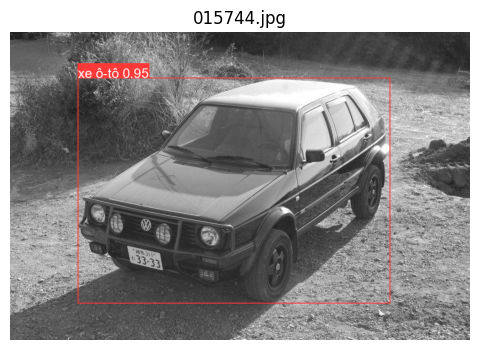

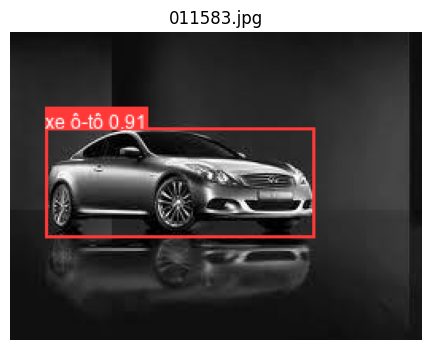

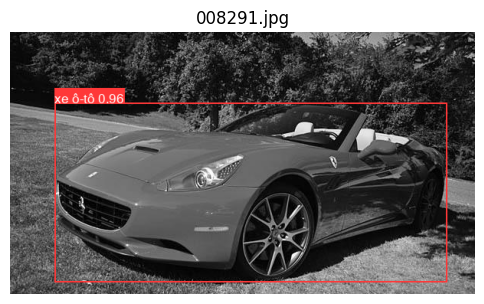

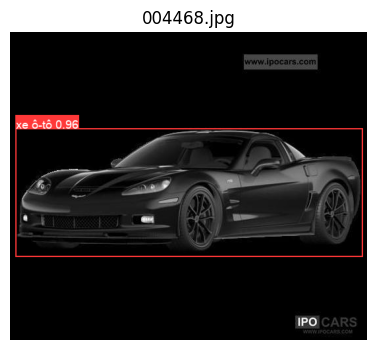

In [ ]:
# 🟢 CELL – INFERENCE PYTHON
from ultralytics import YOLO
import matplotlib.pyplot as plt, cv2, glob, random

model = YOLO("runs/detect/car_yolo112/weights/best.pt")  # load

# lấy 4 ảnh ngẫu nhiên trong tập test
imgs = random.sample(glob.glob(f"{DIR_CAR}/test/images/*.*g"), 4)

for p in imgs:
    res = model(p, imgsz=640, conf=0.3, verbose=False)[0]  # predict
    # vẽ lên ảnh
    im = res.plot()  # ndarray BGR
    plt.figure(figsize=(6,4))
    plt.title(os.path.basename(p))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


In [ ]:
# 🟢 CELL – INFERENCE PYTHON
from ultralytics import YOLO
import matplotlib.pyplot as plt, cv2, glob, random

model = YOLO("runs/detect/car_yolo112/weights/best.pt")  # load

# lấy 4 ảnh ngẫu nhiên trong tập test
imgs = random.sample(glob.glob(f"{DIR_TRAFFIC}/test/images/*.*g"), 4)

for p in imgs:
    res = model(p, imgsz=640, conf=0.3, verbose=False)[0]  # predict
    # vẽ lên ảnh
    im = res.plot()  # ndarray BGR
    plt.figure(figsize=(6,4))
    plt.title(os.path.basename(p))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


In [ ]:
!zip -r /content/sign_yolo85.zip /content/runs/detect/sign_yolo85 > /dev/null

from google.colab import files
files.download("/content/sign_yolo85.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>